In [2]:
import numpy as np
from scipy.special import beta
import matplotlib.pyplot as plt
from scipy.stats import binom

In [3]:
def calc_prob_ab(a_success,a_fail,b_success,b_fail):
    if any([i<0 for i in (a_success,a_fail,b_success,b_fail)]):
        final=0
        return
    final=0; #prob that p_B>p_A
    for i in range (0,b_success+1):
        final=final+beta(a_success+1+i,a_fail+b_fail+2)/((b_fail+i+1)*beta(1+i,b_fail+1)*beta(a_success+1,a_fail+1))
    res=1-final
    return res

def prob_ab(a,b,c,d):
    if any([i<0 for i in (a,b,c,d)]):
        return 0
    if p_cache[a,b,c,d] == -1:
        res = calc_prob_ab(a,b,c,d)
        p_cache[a,b,c,d] = res
        return res
    return p_cache[a,b,c,d]

def r_abcd(a,b,c,d):
    if all([i==0 for i in (a,b,c,d)]):
        return 1
    elif any([i<0 for i in (a,b,c,d)]):
        return 0
    if r_cache[a,b,c,d] == -1:
        res = r_abcd(a-1,b,c,d) * prob_ab(a-1+prior[0],b+prior[1],c+prior[2],d+prior[3]) * p1 + \
              r_abcd(a,b-1,c,d) * prob_ab(a+prior[0],b-1+prior[1],c+prior[2],d+prior[3]) * q1 + \
              r_abcd(a,b,c-1,d) * prob_ab(c-1+prior[2],d+prior[3],a+prior[0],b+prior[1]) * p2 + \
              r_abcd(a,b,c,d-1) * prob_ab(c+prior[2],d-1+prior[3],a+prior[0],b+prior[1]) * q2
        r_cache[a,b,c,d] = res
        return res
    return r_cache[a,b,c,d]

def cache_init(a,b,c,d):
    return -np.ones((a+1,b+1,c+1,d+1), dtype=float)

def arm1dist(n):
    distr=np.zeros(n+1)
    for k in range (n+1):
        for a in range (k+1):
            for c in range (n-k+1):
                distr[k]=distr[k]+r_abcd(a,k-a,c,n-k-c)
    return distr

def type1error(n,v):  #becomes power when p1!=p2, v is decision boundary
    pow=0
    zero=0
    for k in range (n+1):
        for a in range (k+1):
            for c in range (n-k+1):
                n1=k+prior[0]+prior[1]
                n2=n-k+prior[2]+prior[3]
                if any([i==0 for i in [n1,n2]]):
                    zero=zero+r_abcd(a,k-a,c,n-k-c)
                else:
                    pred1=(a+prior[0])/n1
                    pred2=(c+prior[2])/n2 
                    if pred1 in [0,1] and pred2 in [0,1]:
                        zero=zero+r_abcd(a,k-a,c,n-k-c)
                    else:
                        wald=(pred1-pred2)/np.sqrt(pred1*(1-pred1)/n1+pred2*(1-pred2)/n2)
                        if wald>v:
                            pow=pow+r_abcd(a,k-a,c,n-k-c)
    return np.array([pow,zero])

Small sample test
n=25

In [4]:
p_cache= np.load('data.npy')  #always true!

In [56]:
a, b, c, d = 25, 25, 25, 25   #more trials after burn-in period
r_cache = cache_init(a,b,c,d)  #for initial setup only, make sure change when prior change
p1, p2 = 0.8, 0.8
q1, q2 = 1-p1, 1-p2

listoftype1=[]
for burnin in range(13):
    type1=np.array([0,0])
    for i in range(burnin+1):
        for j in range(burnin+1):
            prior=[i,burnin-i,j,burnin-j]
            type1=type1+type1error(24-burnin*2,1.96)*binom.pmf(i,burnin,p1)*binom.pmf(j,burnin,p2)
    listoftype1.append(type1)

[array([0.07179911, 0.01222326]),
 array([0.03676411, 0.00517584]),
 array([0.03273194, 0.00483804]),
 array([0.03022534, 0.00475198]),
 array([0.02967373, 0.00472999]),
 array([0.03003502, 0.00472434]),
 array([0.03058285, 0.00472288]),
 array([0.03240436, 0.0047225 ]),
 array([0.03475201, 0.0047224 ]),
 array([0.03633048, 0.00472238]),
 array([0.03902434, 0.00472237]),
 array([0.04405701, 0.00472237]),
 array([0.0465604 , 0.00472237])]

In [52]:
a, b, c, d = 25, 25, 25, 25   #more trials after burn-in period
r_cache = cache_init(a,b,c,d)  #for initial setup only, make sure change when prior change
p1, p2 = 0.8, 0.2
q1, q2 = 1-p1, 1-p2

listofpow=[]
for burnin in range(13):
    type1=np.array([0,0])
    for i in range(burnin+1):
        for j in range(burnin+1):
            prior=[i,burnin-i,j,burnin-j]
            type1=type1+type1error(24-burnin*2,1.96)*binom.pmf(i,burnin,p1)*binom.pmf(j,burnin,p2)
    listofpow.append(type1)

[array([0.77875632, 0.00783321]),
 array([0.76510207, 0.00479081]),
 array([0.80163457, 0.00474111]),
 array([0.84063679, 0.00472755]),
 array([0.85997418, 0.00472381]),
 array([0.87800532, 0.00472278]),
 array([0.8886866 , 0.00472249]),
 array([0.89919965, 0.0047224 ]),
 array([0.90782226, 0.00472238]),
 array([0.91098392, 0.00472237]),
 array([0.91162158, 0.00472237]),
 array([0.91097072, 0.00472237]),
 array([0.90755531, 0.00472237])]

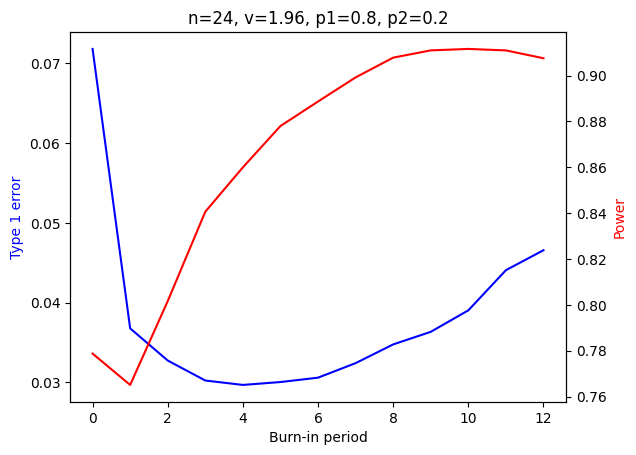

In [57]:
# Extract x and y values for each series
x1 = [point[0] for point in listoftype1]
y1 = [point[0] for point in listofpow]

# Plot the lines
plt.plot(x1, color='blue')
plt.xlabel('Burn-in period')
plt.ylabel('Type 1 error', color='blue')

# Create a twin Axes
plt.twinx()

# Plot the second line
plt.plot(y1, color='red')
plt.ylabel('Power', color='red')

# Add labels and title
plt.title('n=24, v=1.96, p1=0.8, p2=0.2')

# Show plot
plt.show()

n=25, v=0.1 on p1=0.8, p2=0.5 shows that the power initially drops and then bounce back up to be higher than burn-in period=0. This maybe explained by larger stability in estimates after a "long burn-in".

**Fixed burn-in period analysis**

In [1]:
a, b, c, d = 25, 25, 25, 25   #more trials after burn-in period
r_cache = cache_init(a,b,c,d)  #for initial setup only, make sure change when prior change
p1, p2 = 0.5, 0.5
q1, q2 = 1-p1, 1-p2

listoftype1=[]
burnin=0
for burnin in range(13):
    type1=np.array([0,0])
    for i in range(burnin+1):
        for j in range(burnin+1):
            prior=[i,burnin-i,j,burnin-j]
            type1=type1+type1error(24-burnin*2,1.96)*binom.pmf(i,burnin,p1)*binom.pmf(j,burnin,p2)
    listoftype1.append(type1)



NameError: name 'cache_init' is not defined

In [83]:
np.save('data.npy', p_cache)